In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline
import matplotlib.colors as colors


In [3]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
from ecl.eclfile import EclFile
from ecl.eclfile import EclInitFile, EclRestartFile
from ecl.grid import EclGrid
#import rips 

In [5]:
!python -V

Python 3.8.17


In [6]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [7]:
# GaP
from src.GaP.libs.models import (
    PipeCementModel,
    ElemModel,
    DepthModel,
)

from src.GaP.libs.carfin import build_grdecl

In [8]:
# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)
from src.WellClass.libs.grid_utils.LGR_grid_utils import (
    compute_ngrd,
    generate_LGR_xy,
    generate_LGR_z,
)
from src.WellClass.libs.grid_utils.LGR_bbox import (
    get_ij_indices,
    get_k_indices,
)
from src.WellClass.libs.grid_utils.df2gap import (
    to_gap_casing_list,
    to_gap_barrier_list
)


# plots
from src.WellClass.libs.plotting import plot_well_perm

## Some user options

In [9]:
# TODO(hzh): use Ali's algorithm
Ali_way = False

In [10]:
# use yaml or csv input file
use_yaml = True

In [11]:
# pick an example from given three options

case_type = 'cosmo'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

# Examples

The following are the test examples.

In [12]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
cosmo = {
         'well_input': r'GaP_input_Cosmo_v3.csv', 
         'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/cosmo', 
         'simcase': r'TEMP-0'}

In [13]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [14]:
# the selected example for testing
case = examples[case_type]


In [15]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

# where the location for the input parameters and eclipse .EGRID and .INIT files
sim_path = case['sim_path']


In [16]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [17]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

# Loading the model

- Load the PFT grid, init and restart files.
- Grid contains geometry specs
- INIT contains static properties (i.e. poro., perm., transmissibilities)
- RST contains dynamic properties (i.e. saturations, pressure)


In [18]:
# simulation case without legacy well 

# path = '/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model'

# location of .egrid
simcase = os.path.join(sim_path, case['simcase'])

#Get grid dimensions and coordinates
grid = EclGrid(simcase + ".EGRID") 
#init = EclGrid(simcase + ".INIT") 
init = EclInitFile(grid, simcase + ".INIT")
# restart file
# rst = EclRestartFile(grid, simcase + ".UNRST")

## The grid dimensions

In [19]:
NX, NY, NZ, total = grid.get_dims()
NX, NY, NZ, total

(20, 20, 82, 32800)

# Store INIT parameters into a Pandas Dataframe: grid_init

In [20]:
grid_init = grid.export_index()

In [21]:
# Static properties Dataframe
for key in init.keys():
        try:
                grid_init[key] = init[key][0].numpy_view()
        except:
                continue

In [22]:
#Create cell coordinate X, Y, Z

# generate cell coordinates by shifting half cell size
xcoord = (grid_init.query("j==0&k==0").DX.cumsum() - grid_init.query("j==0&k==0").DX/2).values
ycoord = (grid_init.query("i==0&k==0").DY.cumsum() - grid_init.query("i==0&k==0").DY/2).values
zcoord = (grid_init.query("i==0&j==0").DZ.cumsum() - grid_init.query("i==0&j==0").DZ/2).values

# TODO(hzh): a bug?
# map_X = dict(zip(grid_init.query("j==0&j==0")['i'], xcoord))
map_X = dict(zip(grid_init.query("j==0&k==0")['i'], xcoord))
map_Y = dict(zip(grid_init.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(grid_init.query("i==0&j==0")['k'], zcoord))

# save cell coordinates to DataFrame
grid_init['X'] = grid_init['i'].map(map_X)
grid_init['Y'] = grid_init['j'].map(map_Y)
grid_init['Z'] = grid_init['k'].map(map_Z)

## Plot well sketch and 2D slice of the permeability, at coarse grid.

In [23]:
# middle indices of x and y
mid_i = grid_init.i.max()//2
mid_j = grid_init.j.max()//2

In [24]:
# generate grid coordinates for plotting

# grid coordinates
xcorn  = (grid_init.query("j==0&k==0").DX.cumsum()).values
ycorn  = (grid_init.query("i==0&k==0").DY.cumsum()).values
zcorn  = (grid_init.query("i==0&j==0").DZ.cumsum()).values

# add origin coordinates
xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

In [25]:
# shift grid coordinates half-length in x-y directions, i.e., [0, 3900] => [-1900, 2100]
# but not in z direction
xcorn -= xcoord[mid_i]
ycorn -= ycoord[mid_j]

In [26]:
# extract 2D xz slice at middle of y
XZ_slice = grid_init.query('j==@mid_j')

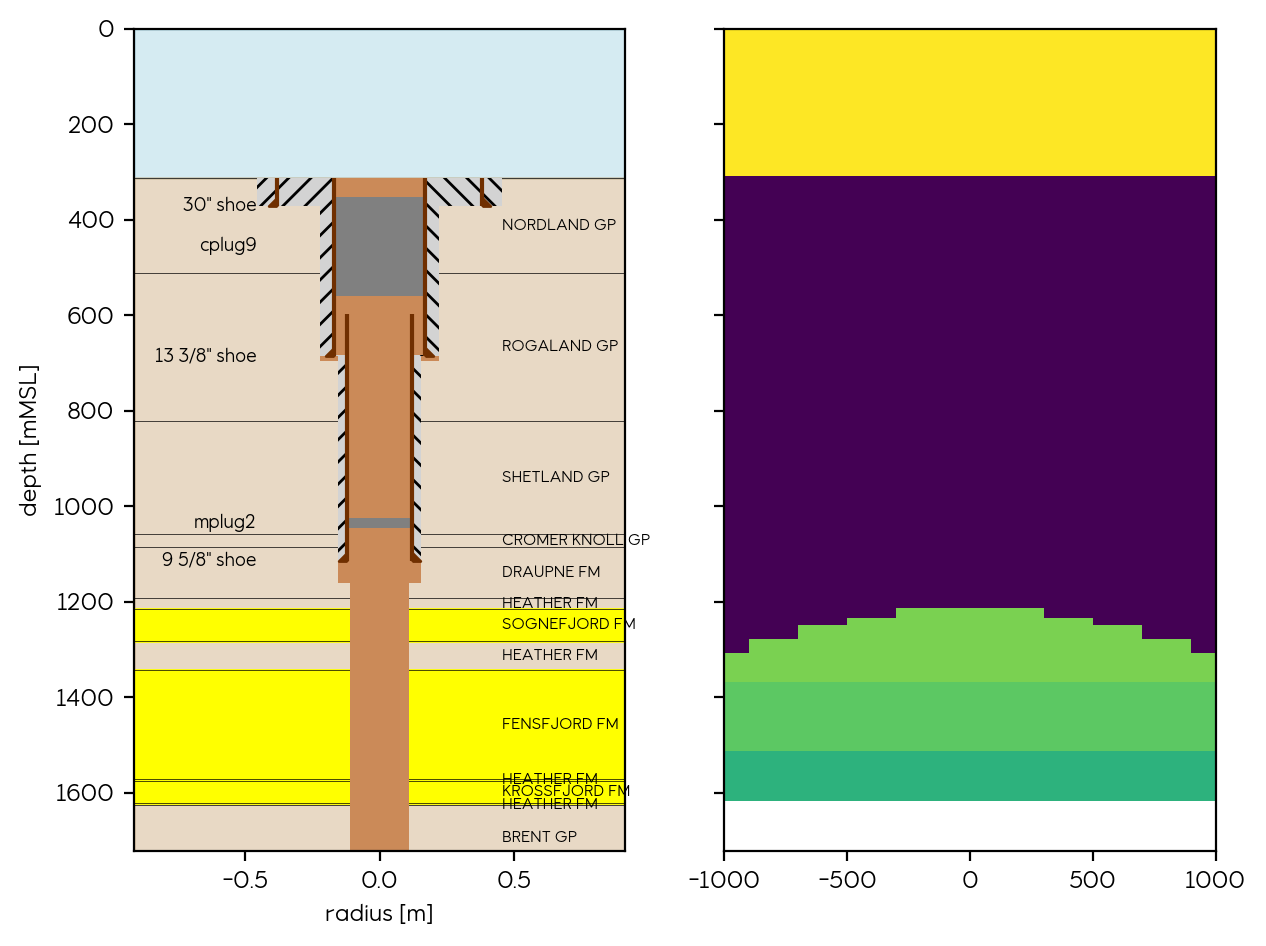

In [27]:

# extract permeability
Z = XZ_slice.PERMX.values.reshape(NZ, NX)

# plot x-z slice
plot_well_perm(my_well, x=xcorn, y=zcorn, Z=Z, on_coarse=True)

# Grid information for coarse grid

In [28]:
# Retrieve coarse x-y grid indexes where LGR will be placed

# TODO(hzh): 
#   1) why switch i and j? 
main_grd_i     = grid_init.j.max()//2
main_grd_j     = grid_init.i.max()//2

# Rettrieve min and max k-index for column where LGR will be placed
# TODO(hzh): Do I need to add 1 here?
main_grd_min_k = grid_init.k.min()
main_grd_max_k = grid_init.k.max()

In [29]:
# Retrieve coarse cell sizes
main_grd_dx = grid_init.query('i == @main_grd_i & j == @main_grd_j & k == k.min()')['DX'].iloc[0]
main_grd_dy = grid_init.query('i == @main_grd_i & j == @main_grd_j & k == k.min()')['DY'].iloc[0]


In [30]:

# Retrieve all DZ in coarse grid, not used
main_DZ = grid_init.query('i == @main_grd_i & j == @main_grd_j')['DZ'].values

main_DEPTH = grid_init.query('i == @main_grd_i & j == @main_grd_j')['DEPTH'].values

# depth where LGR starts
ref_depth = 0
if Ali_way:
    ref_depth = main_DEPTH[0] - 0.5*main_DZ[0]
    

In [31]:
ref_depth

0

In [32]:
#Retrieve number of cells representing water column and overburden
no_of_layers_in_OB    = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ >  10')['DZ'].shape[0]
no_of_layers_below_OB = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= 10')['DZ'].shape[0]

no_of_layers_in_OB, no_of_layers_below_OB

(10, 72)

# Dataframes for drilling, casings, borehole and barriers

In [33]:
# dataframes for the well
drilling_df = pd.DataFrame(my_well.drilling)
casings_df = pd.DataFrame(my_well.casings)
borehole_df = pd.DataFrame(my_well.borehole)

# and for the barriers
barriers_df = pd.DataFrame(my_well.barriers)
barriers_mod_df = pd.DataFrame(my_well.barriers_mod)

In [34]:
# Compute annulus thickness. 
# For simplicty it assumes annulus between casing and openhole as entire annulus

casings_df['ann_od_m'] = np.nan
casings_df['ann_bottom_msl'] = np.nan

# casing
for idx, row in casings_df[::-1].iterrows():

        # get id from casing
        d, top, bottom = row[['diameter_m', 'top_msl', 'bottom_msl']]

        # get od from drilling
        hole = drilling_df[drilling_df['diameter_m'] > d].iloc[-1]
    
        hole_top, hole_bottom, hole_d = hole[['top_msl', 'bottom_msl', 'diameter_m']]

        casings_df.loc[idx, 'ann_od_m'] = hole_d       # outer diameter in meters
        casings_df.loc[idx, 'ann_bottom_msl'] = hole_bottom

#Compute inner area
casings_df['A_i'] = np.pi * (casings_df['diameter_m']/2)**2

#Compute outer area
casings_df['A_o'] = np.pi * (casings_df['ann_od_m']/2)**2

# annulus thickness: (od-id)/2
casings_df['thick_m'] = (casings_df['ann_od_m'] - casings_df['diameter_m'])/2

# LGR grid information in x, y, z directions

We are going to compute the grid sizes in lateral (x and y) and vertical directions

### 1. Compute minimum grid size

In [35]:
# 0. minimum grid size

# minimum grid size depends on minimum annulus thickness
min_grd_size = casings_df['thick_m'].min()

if min_grd_size < 0.05:
    min_grd_size = 0.05

print(f'Minimimum grid size is {min_grd_size*100:.2f} cm')

Minimimum grid size is 5.00 cm


In [36]:
# TODO(hzh): manually set it
if Ali_way:
    min_grd_size = 0.05

In [37]:
# 1. compute number of LGR grids for drilling, casing and borehole, respectively

# for drilling
drilling_df['n_grd_id']  = drilling_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))

# the following two are used in ...
casings_df[ 'n_grd_id']  = casings_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))
borehole_df['n_grd_id'] = borehole_df['id_m'].map(lambda x: compute_ngrd(x, min_grd_size))

### 2. Compute LGR grid sizes in x-y directions

In [38]:
# 2. compute LGR grid sizes in x-y directions

# 2.1 Number of cells representing horizontal LGR
no_latral_fine_grd = drilling_df['n_grd_id'].max()
no_latral_fine_grd

16

In [39]:
# 2.2 generate the LGR grid sizes in x-y
LGR_sizes_x, LGR_sizes_y, _ = generate_LGR_xy(no_latral_fine_grd, 
                                              min_grd_size, 
                                              main_grd_dx, main_grd_dy,
                                              Ali_way=Ali_way)

### 3. Compute LGR grid sizes in z direction

In [40]:
# 3. Compute LGR grid sizes in z direction

# the dz value to distinguish zones between reservoir and ovb
dz0 = 10

# 3.1 DZs for reservoir
DZ_rsrv = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= @dz0')['DZ'].values

# 3.2 DZs for coarse grid
DZ_ovb_coarse = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ > @dz0')['DZ'].values

# 3.3 generate the LGR grid sizes in z
# LGR_sizes_z, LGR_numb_z, LGR_depths, _ = generate_LGR_z(DZ_rsrv, DZ_ovb_coarse)
# TODO(hzh): to make LGR starts at ref_depth
LGR_sizes_z, LGR_numb_z, LGR_depths, _ = generate_LGR_z(DZ_rsrv, DZ_ovb_coarse, ref_depth)

In [41]:
# LGR dimensions
nx = len(LGR_sizes_x)
ny = len(LGR_sizes_y)
nz = len(LGR_sizes_z)

nx, ny, nz

(22, 22, 172)

# Set up dataframe for LGR mesh

In [42]:
#Create i, j, k indices
cell_ijk = np.indices((nx, ny, nz))
cell_ijk = cell_ijk.reshape((3, nx * ny * nz)).T

In [43]:
#Create LGR Dataframe with indices
mesh_df = pd.DataFrame(data = cell_ijk, columns = ['i', 'j', 'k'])

mesh_df.sort_values(by=['k', 'i'], inplace = True)
mesh_df.reset_index(inplace=True, drop=True)

In [44]:
#Creat DX, DY, DZ for LGR mesh
DX_grid, DZ_grid, DY_grid = np.meshgrid(LGR_sizes_x, LGR_sizes_z, LGR_sizes_y)

mesh_df['DX'] = DX_grid.flatten()
mesh_df['DY'] = DY_grid.flatten()
mesh_df['DZ'] = DZ_grid.flatten()

In [45]:
#Create cell coordinate X, Y, Z for LGR mesh

# cell coordinates
xcoord = (mesh_df.query("j==0&k==0").DX.cumsum() - mesh_df.query("j==0&k==0").DX/2).values
ycoord = (mesh_df.query("i==0&k==0").DY.cumsum() - mesh_df.query("i==0&k==0").DY/2).values
zcoord = (mesh_df.query("i==0&j==0").DZ.cumsum() - mesh_df.query("i==0&j==0").DZ/2).values

# TODO(hzh): a bug?
# map_X = dict(zip(mesh_df.query("j==0&j==0")['i'], xcoord))
map_X = dict(zip(mesh_df.query("j==0&k==0")['i'], xcoord))
map_Y = dict(zip(mesh_df.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(mesh_df.query("i==0&j==0")['k'], zcoord))

# save cell coordinates X, Y, Z to dataframe
mesh_df['X'] = mesh_df['i'].map(map_X)
mesh_df['Y'] = mesh_df['j'].map(map_Y)
mesh_df['Z'] = mesh_df['k'].map(map_Z)

In [46]:
# save Corner Z points to dataframe
mesh_df['Zcorn_top'] = mesh_df['Z'] - mesh_df['DZ']/2
mesh_df['Zcorn_bottom'] = mesh_df['Z'] + mesh_df['DZ']/2

## Upscale coarse properties to LGR grids

In [47]:
# indices for center finer grid
mid_i = mesh_df.i.max()//2
mid_j = mesh_df.j.max()//2
mid_i, mid_j

(10, 10)

In [48]:
# properties
fields = ['PORV', 
          'PERMX', 'PERMY', 'PERMZ', 
          'MULTX', 'MULTY', 'MULTZ', 
          'MULTX-', 'MULTY-', 'MULTZ-', 
          'PORO']

In [49]:
# Upscale coarse properties to LGR grids

for field in fields:
    # mesh_df[field] = np.nan
    mesh_df[field] = 0.0                    # TODO(hzh): what should I put here?
    
for idx, row in grid_init.query('i==@mid_i & j==@mid_j').iterrows():

    # switch to corner coords, coarse grid
    top  = row.Z - row.DZ/2
    base = row.Z + row.DZ/2

    for field in fields:

        mesh_df.loc[(mesh_df['Z']>=top) & (mesh_df['Z']<base), field] = row[field]


# Bounding box for well elements

Compute bounding boxes for drillings, casings and barriers.

### 1. Drillings

In [50]:
# 1. compute bounding box of drillings

drilling_df['k_min'] = np.nan
drilling_df['k_max'] = np.nan
drilling_df['ij_min'] = np.nan
drilling_df['ij_max'] = np.nan

for idx, row in drilling_df.iterrows():
    
    top, bottom = row['top_msl'], row['bottom_msl']

    if top < mesh_df['Zcorn_bottom'].max():
        
        # k ranges
        k_min, k_max = get_k_indices(mesh_df, top, bottom)

        # x-y ranges
        ij_min, ij_max = get_ij_indices(nx, row['n_grd_id'])

        # to dataframe
        drilling_df.loc[idx, 'k_min'] = k_min
        drilling_df.loc[idx, 'k_max'] = k_max
        drilling_df.loc[idx, 'ij_min'] = ij_min
        drilling_df.loc[idx, 'ij_max'] = ij_max

### 2. Casings

In [51]:
# 2. computing bounding boxes of casings

# casing, k
casings_df['k_min'] = np.nan
casings_df['k_max'] = np.nan
# cement bond, k
casings_df['toc_k_min'] = np.nan
casings_df['toc_k_max'] = np.nan
# casing, xy
casings_df['ij_min'] = np.nan
casings_df['ij_max'] = np.nan

for idx, row in casings_df.iterrows():

    # A) casing, z ranges
    top, bottom  = row['top_msl'], row['bottom_msl']
    
    # convert to indices
    k_min, k_max = get_k_indices(mesh_df, top, bottom)
    
    # B) cement, z ranges
    toc, boc = row['toc_msl'], row['boc_msl']

    # convert to indices
    toc_k_min, toc_k_max = get_k_indices(mesh_df, toc, boc)
    
    # C) xy ranges
    ij_min, ij_max = get_ij_indices(nx, row['n_grd_id'])
    
    # to dataframe
    casings_df.loc[idx, 'k_min'] = k_min
    casings_df.loc[idx, 'k_max'] = k_max
    casings_df.loc[idx, 'toc_k_min'] = toc_k_min
    casings_df.loc[idx, 'toc_k_max'] = toc_k_max
    casings_df.loc[idx, 'ij_min'] = ij_min
    casings_df.loc[idx, 'ij_max'] = ij_max

### 3. Barriers

In [52]:
# 3. computing bounding boxes of barriers

barriers_mod_df['k_min'] = np.nan
barriers_mod_df['k_max'] = np.nan
for idx, row in barriers_mod_df.iterrows():
    
    k_min, k_max = get_k_indices(mesh_df, row.top_msl, row.bottom_msl)
    
    barriers_mod_df.loc[idx, 'k_min'] = k_min
    barriers_mod_df.loc[idx, 'k_max'] = k_max

# Assign material types in mesh

Assign material types, such as openholes, overburden, cement bond, etc.

In [53]:
# initialize material to overburden
mesh_df['material'] = 'overburden'

### 1. Drilling

In [54]:
# 1. set material type
for idx, row in drilling_df.iterrows():
    
    top, bottom = row['top_msl'], row['bottom_msl']

    if top < mesh_df['Zcorn_bottom'].max():

        # extract bounding box
        k_min, k_max = row['k_min'], row['k_max']
        ij_min, ij_max = row['ij_min'], row['ij_max']
        
        # 1.1 set material type to openhole
        criteria =  '(k >= @k_min) & (k <= @k_max) & (i >= @ij_min) & (i <= @ij_max) & (j >= @ij_min) & (j <= @ij_max)'
        mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'

### 2. Casings

In [55]:
# 2. set material types to casings
for ic, (idx, row) in enumerate(casings_df.iterrows()):

    # extract bounding box
    k_min, k_max = row['k_min'], row['k_max']
    ij_min, ij_max = row['ij_min'], row['ij_max']
    toc_k_min, toc_k_max = row['toc_k_min'], row['toc_k_max']
    
    # 2.1 set material type to annulus
    # x
    criteria_i =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((i < @ij_min) | (i > @ij_max))'
    mesh_df.loc[mesh_df.eval(criteria_i), 'material'] = 'annulus'
    # y
    criteria_j =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((j < @ij_min) | (j > @ij_max))'
    mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'annulus'
    
    # 2.2 set material type to cement_bond
    criteria = '(material == "annulus") & (k >= @toc_k_min) & (k <= @toc_k_max)' 
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = f'cement_bond_{ic}'

    # 2.3 set material type to openhole
    criteria = '(material == "annulus")'  
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'
    # mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'cementbond'   

### 3. Barriers

In [56]:
# 3. set material type to barrier
for ib, (idx, row) in enumerate(barriers_mod_df.iterrows()):
    
    b_k_min, b_k_max = row['k_min'], row['k_max']
    
    criteria = '(material == "openhole") & (k >= @b_k_min) & (k <= @b_k_max)' 
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = f'barrier_{ib}'

# Assign permeability according to material type

In [57]:
barriers_mod_df

,b_name,top_msl,bottom_msl,diameter_m,barrier_perm,k_min,k_max
cplug9_0,cplug9,351.5,559.5,0.339725,0.5,14.0,35.0
mplug2_1,mplug2,1025.5,1045.5,0.244475,100.0,81.0,83.0


In [58]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,cb_perm,diameter_m,top_msl,bottom_msl,...,A_i,A_o,thick_m,n_grd_id,k_min,k_max,toc_k_min,toc_k_max,ij_min,ij_max
0,335.5,394.0,30.000,335.5,394.0,True,5,0.762000,312.0,370.5,...,0.456037,0.656693,0.076200,14,10.0,16.0,10.0,16.0,4.0,17.0
1,335.5,709.0,13.375,335.5,709.0,True,5,0.339725,312.0,685.5,...,0.090645,0.155179,0.052388,6,10.0,47.0,10.0,47.0,8.0,13.0
2,622.0,1137.5,9.625,706.0,1137.5,True,5,0.244475,598.5,1114.0,...,0.046942,0.076038,0.033337,4,39.0,90.0,47.0,90.0,9.0,12.0


In [59]:
drilling_df

,top_rkb,bottom_rkb,diameter_in,oh_perm,diameter_m,top_msl,bottom_msl,n_grd_id,k_min,k_max,ij_min,ij_max
0,335.5,395,36.00,10000,0.91440,312.0,371.5,16,10.0,16.0,3.0,18.0
1,395.0,720,17.50,10000,0.44450,371.5,696.5,8,16.0,48.0,7.0,14.0
2,720.0,1185,12.25,10000,0.31115,696.5,1161.5,6,48.0,95.0,8.0,13.0
3,1185.0,3186,8.50,10000,0.21590,1161.5,3162.5,4,95.0,171.0,9.0,12.0


In [60]:
# set permeability according to material type

# 1. openhole
oh_perm = drilling_df['oh_perm'].iloc[0]
criteria = 'material == "openhole"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = oh_perm

# 2. cement bond
for ic, (_, row) in enumerate(casings_df.iterrows()):
    cb_perm = row['cb_perm']
    criteria = f'material == "cement_bond_{ic}"'
    mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = cb_perm

# 3. barrier
for ib, (_, row) in enumerate(barriers_mod_df.iterrows()):
    barrier_perm = row['barrier_perm']
    criteria = f'material == "barrier_{ib}"'
    mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = barrier_perm

# Visualization of well sketch and LGR grids

In [61]:
# grid coordinates at LGR grids for plotting
xcorn  = (mesh_df.query("j==0&k==0").DX.cumsum()).values
ycorn  = (mesh_df.query("i==0&k==0").DY.cumsum()).values
zcorn  = (mesh_df.query("i==0&j==0").DZ.cumsum()).values

# add origin
xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

# shift it
xcorn -= main_grd_dx/2
ycorn -= main_grd_dy/2

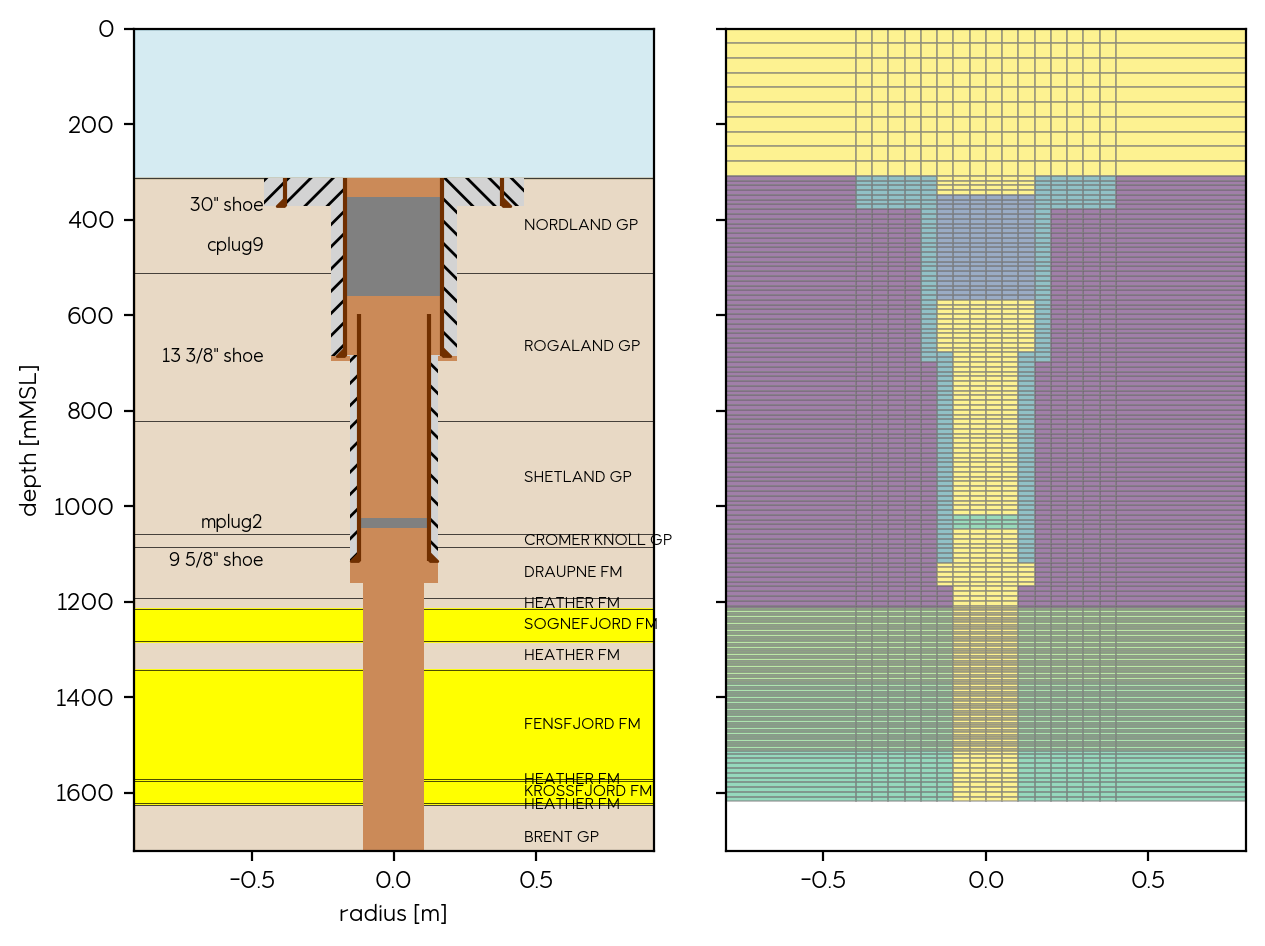

In [62]:

# LGR
XZ_slice = mesh_df.query('j==@mid_i')

# extract permeability value
Z = XZ_slice.PERMX.values.reshape(nz, nx)

# plot it
plot_well_perm(my_well, x=xcorn, y=zcorn, Z=Z, on_coarse=False)


# Write LGR file

In [63]:
output_dir = '.'

In [64]:
# LRG name 
LGR_NAME = 'LEG_HIRES'

In [65]:
# prepare info about Casing, Cement Bond and Open hole  for GaP
casing_list = to_gap_casing_list(drilling_df, 
                              casings_df)

# prepare info about Barrier for GaP 
barrier_list = to_gap_barrier_list(barriers_mod_df)

DEBUG ==============> handling open hole section


In [66]:
# generate .grdecl file
# TODO(hzh): add 1s to indices here
build_grdecl(output_dir, LGR_NAME,
                casing_list,
                barrier_list,
                LGR_sizes_x, 
                LGR_depths, 
                LGR_numb_z, 
                min_grd_size,
                grid.getNX(), grid.getNY(),
                main_grd_i + 1, main_grd_j + 1,
                main_grd_min_k + 1, main_grd_max_k + 1,
                no_of_layers_in_OB)

...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
...Prints Casings, cement bonds and barrie(s) in LEG_HIRES.grdecl file
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /scratch/SCS/hzh/junk/SCREEN/notebooks/LEG_HIRES.grdecl


In [67]:
!ls -l LEG_HIRES.grdecl*

-rw-rw-r-- 1 hzh scs_ccs 5739 Sep 22 03:10 LEG_HIRES.grdecl
-rw-rw-r-- 1 hzh scs_ccs 5383 Sep 21 01:59 LEG_HIRES.grdecl.smeaheia


In [68]:
# check the results, only compare smeaheia_v1
if case_type == 'smeaheia_v1' and Ali_way:
    !diff LEG_HIRES.grdecl LEG_HIRES.grdecl.smeaheia